# 0. Install Dependencies and Bring in Data

In [ ]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
# Load train
df = pd.read_csv('LabeledDataset.csv')
df=df[['commentText','Label']]
df=df.drop_duplicates()
df

,commentText,Label
0,شمس مثقفة و جميلة وايد ... و احلام ههههععع ما ...,P
1,احلام اني حبيتها اكثر لان انظلمت كثير من النا...,N
2,كبرلفك والله دايضحكون عليج,N
3,والله كلامه صحيح عن شمس,N
4,ذكرى ما نسيناك وما حد بينسينا صوتك الجميل وطيب...,N
...,...,...
15044,ماذا ننتظر من واحدة مسيحية عاهرة لك تفو على هي...,P
15045,مغروره تاليتج ياكلج الدود,P
15046,معقول رامز الكلب يعمل هالمقلب بسيرين هذا الاعد...,P
15048,كنت بحبا بس المقطع رقم 2 خلاها قزرة,P


# 2. Preprocess

In [ ]:
!git clone https://github.com/aub-mind/arabert
!pip install pyarabic
!pip install farasapy
import Ara_preprocessor # our file that contains the preprocessing methods

In [10]:
clean_df=df.copy()
len(clean_df)

11100

In [11]:
for i in range(15051):
  try:
    commentText=clean_df['commentText'][i]
    commentText=Ara_preprocessor.Pre_processing(commentText)
    clean_df['commentText'][i]=commentText
  except:
    commentText

In [12]:
clean_df= clean_df.dropna()
clean_df=clean_df.drop_duplicates()

In [13]:
clean_df

,commentText,Label
0,شمس مثقف جميل وايد أحلام ههعع ما أقول,P
1,أحلام حبي أكثر لان انظلم كثير من ناس هي امرا ق...,N
2,كبرلفك الله دايضحكون عليج,N
3,الله كلام صحيح عن شمس,N
4,ذكرى ما نسي ما حد ينسي صوت جميل طيب قدر غير مو...,N
...,...,...
15044,ماذا ننتظر من واحد مسيحي عاهر تفو علي هي أشكال...,P
15045,مغرور تاليتج ياكلج دود,P
15046,معقول رامز كلب يعمل هالمقلب سير هذا إعدام قليل حق,P
15048,حبا بس مقطع رقم خلا قزره,P


In [14]:
clean_df["Label"].value_counts() 

N    6250
P    4624
Name: Label, dtype: int64

In [15]:
from sklearn.preprocessing import LabelEncoder


# encode class values as integers
encoder = LabelEncoder()
encoder.fit(clean_df['Label'])
clean_df['Label'] = encoder.transform(clean_df['Label'])
clean_df

,commentText,Label
0,شمس مثقف جميل وايد أحلام ههعع ما أقول,1
1,أحلام حبي أكثر لان انظلم كثير من ناس هي امرا ق...,0
2,كبرلفك الله دايضحكون عليج,0
3,الله كلام صحيح عن شمس,0
4,ذكرى ما نسي ما حد ينسي صوت جميل طيب قدر غير مو...,0
...,...,...
15044,ماذا ننتظر من واحد مسيحي عاهر تفو علي هي أشكال...,1
15045,مغرور تاليتج ياكلج دود,1
15046,معقول رامز كلب يعمل هالمقلب سير هذا إعدام قليل حق,1
15048,حبا بس مقطع رقم خلا قزره,1


In [16]:
# Shuffle the data
clean_df=clean_df.sample(frac = 1)

In [17]:
clean_df["Label"][7000:].value_counts() 

0    2209
1    1665
Name: Label, dtype: int64

# 3. AraBERT Tokenaization

In [18]:
X = clean_df['commentText'].values
y = clean_df['Label'].values

In [ ]:
!pip install transformers
from transformers import AutoTokenizer, AutoModel

In [ ]:
tokenizer = AutoTokenizer.from_pretrained( "aubmindlab/bert-base-arabertv2")

In [21]:
from tensorflow.python.ops import tensor_array_ops

def Tokenize(X):
  toke=[]
  for sentence in X:
    m=np.zeros(800)
    inputs= np.array(tokenizer(str(sentence), padding=True,
                  return_tensors='pt',truncation=False, max_length=800)['input_ids'][0] )
    m[:inputs.shape[0]-2]=inputs[1:-1]
    toke.append(m.astype(int))
  return toke  
 

In [22]:
toke=Tokenize(X)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2354: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2354: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [23]:
tokenized_text = tf.convert_to_tensor(toke)

In [24]:
len(tokenized_text)

10874

In [25]:
MAX_FEATURES = 200000 # number of words in the vocab

In [26]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((tokenized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(16000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [53]:
# Split the data into train, validation and test
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 4. Create Sequential Model

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding, Conv1D, GRU ,RNN, GlobalMaxPooling1D,SimpleRNN

In [56]:
# CNN, LSTM, BLSTM, attention BLSTM,

In [57]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 200))


# # Bidirectional LSTM Layer
# model.add(LSTM(32, activation='tanh'))
model.add(Conv1D(128,5,activation='relu'))
# model.add(GlobalMaxPooling1D())
# model.add(SimpleRNN(64,return_sequences= True))
# model.add(GRU(128, return_sequences = True))
model.add(Bidirectional(LSTM(32, activation='tanh')))

# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(1, activation='sigmoid'))

In [58]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam',metrics=['accuracy'])

In [59]:
# model.build(train) # `input_shape` is the shape of the input data


In [60]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 200)         40000200  
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         128128    
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                      

In [61]:
history = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
475/475 [==============================] - 34s 66ms/step - loss: 0.4909 - accuracy: 0.7536 - val_loss: 0.2735 - val_accuracy: 0.8934
Epoch 2/20
475/475 [==============================] - 31s 64ms/step - loss: 0.2699 - accuracy: 0.8934 - val_loss: 0.1758 - val_accuracy: 0.9439
Epoch 3/20
475/475 [==============================] - 31s 66ms/step - loss: 0.1770 - accuracy: 0.9343 - val_loss: 0.0936 - val_accuracy: 0.9692
Epoch 4/20
475/475 [==============================] - 31s 64ms/step - loss: 0.1053 - accuracy: 0.9632 - val_loss: 0.0799 - val_accuracy: 0.9784
Epoch 5/20
475/475 [==============================] - 30s 64ms/step - loss: 0.0676 - accuracy: 0.9758 - val_loss: 0.0369 - val_accuracy: 0.9908
Epoch 6/20
475/475 [==============================] - 30s 64ms/step - loss: 0.0397 - accuracy: 0.9868 - val_loss: 0.0212 - val_accuracy: 0.9945
Epoch 7/20
475/475 [==============================] - 31s 64ms/step - loss: 0.0351 - accuracy: 0.9883 - val_loss: 0.0146 - val_accuracy:

In [ ]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

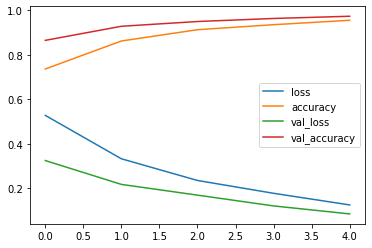

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [ ]:
input_text = Tokenize('شكلها زي الحيوان')
# input_text

In [ ]:
res = model.predict(np.array([input_text]))

1/1 [==============================] - 1s 906ms/step


In [ ]:
(np.rint(res)).astype(int)

array([[0]])

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

In [ ]:
res

array([[0.2216914]], dtype=float32)

# 4. Evaluate Model

In [62]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [63]:
from sklearn.metrics import f1_score
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()


In [ ]:
t=[]
p=[]
for batch in test.as_numpy_iterator(): 

    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat =(np.rint(model.predict(X_true))).astype(int)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    t=np.concatenate((t,y_true), axis=None)
    p=np.concatenate((p,yhat), axis=None)
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)
    f1_score(y_true,yhat)

In [ ]:
import sys
import numpy

numpy.set_printoptions(threshold=sys.maxsize)

t,p

In [66]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()},F1_score:{f1_score(t,p)}')

Precision: 1.0, Recall:1.0, Accuracy:1.0,F1_score:1.0


# 5. Test and Gradio

In [ ]:
!pip install gradio jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 84.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 89.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.5/270.5 KB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━

In [ ]:
import tensorflow as tf
import gradio as gr

In [ ]:
model.save('toxicity.h5')

In [ ]:
model = tf.keras.models.load_model('toxicity.h5')

In [ ]:
input_str=Tokenize(['ههههه والله كيوت'])

In [ ]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 0s 171ms/step


In [ ]:
res

array([[0.00313994]], dtype=float32)

In [ ]:
def score_comment(comment):
    vectorized_comment = Tokenize([[comment]])
    results = model.predict(vectorized_comment)
    text = '{}: {}'.format("Label",(np.rint(results)).astype(int))
    
    return text

In [ ]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/gradio/routes.py", line 322, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.8/dist-packages/gradio/blocks.py", line 1015, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.8/dist-packages/gradio/blocks.py", line 833, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/loc

In [ ]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://9b10a306-2b02-4774.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
